# Other Samplers

Trey V. Wenger (c) August 2024

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.0+0.gafc48ae.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

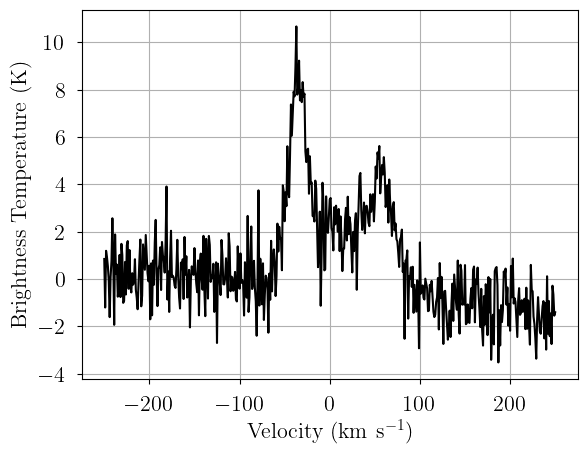

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's use a lot of chains and the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 8,
    cores = 8,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


In [7]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [2 1 0]
Chain 2 order: [2 1 0]
Chain 3 order: [2 0 1]
Chain 4 order: [1 2 0]
Chain 5 order: [1 0 2]
Chain 6 order: [1 0 2]
Chain 7 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

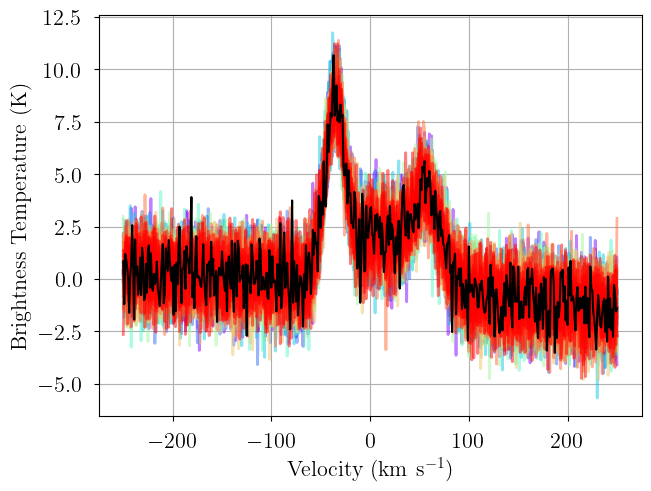

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

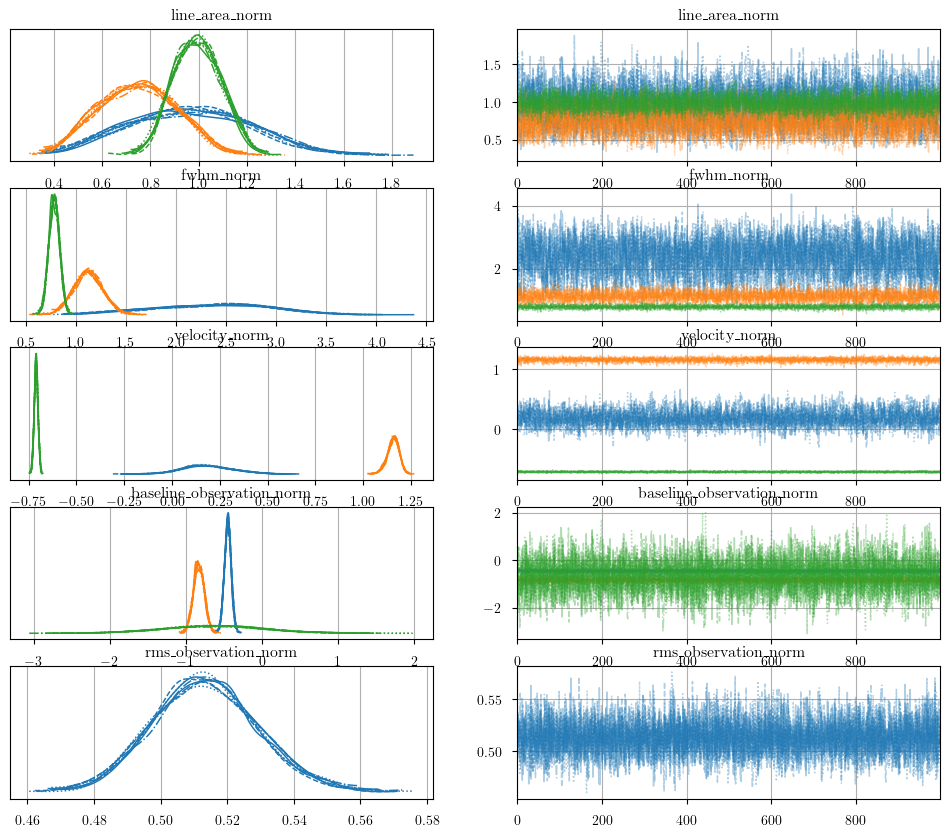

In [9]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    2.573   0.221    2.171    2.996      0.003   
amplitude[1]                    4.137   0.508    3.232    5.082      0.009   
amplitude[2]                    7.939   0.463    7.083    8.810      0.007   
baseline_observation_norm[0]   -0.452   0.045   -0.540   -0.369      0.001   
baseline_observation_norm[1]   -0.832   0.072   -0.975   -0.706      0.001   
baseline_observation_norm[2]   -0.635   0.672   -1.898    0.648      0.009   
fwhm[0]                        70.714  17.302   38.327  101.245      0.344   
fwhm[1]                        33.662   4.325   25.404   41.510      0.076   
fwhm[2]                        23.502   1.575   20.520   26.375      0.026   
fwhm_norm[0]                    2.357   0.577    1.278    3.375      0.011   
fwhm_norm[1]                    1.122   0.144    0.847    1.384      0.003   
fwhm_norm[2]                    0.783   0.052    0.684    0.879      0.001   
line_area[0]                  193.370  49.916  100.412  281.146      0.990   
line_area[1]                  149.323  31.679   92.322  206.387      0.623   
line_area[2]                  198.811  19.745  164.889  237.043      0.376   
line_area_norm[0]               0.967   0.250    0.502    1.406      0.005   
line_area_norm[1]               0.747   0.158    0.462    1.032      0.003   
line_area_norm[2]               0.994   0.099    0.824    1.185      0.002   
rms_observation                 1.027   0.032    0.965    1.086      0.000   
rms_observation_norm            0.513   0.016    0.482    0.543      0.000   
velocity[0]                     9.426   6.562   -1.968   22.633      0.115   
velocity[1]                    57.795   1.552   54.796   60.623      0.025   
velocity[2]                   -35.532   0.487  -36.393  -34.548      0.006   
velocity_norm[0]                0.189   0.131   -0.039    0.453      0.002   
velocity_norm[1]                1.156   0.031    1.096    1.212      0.000   
velocity_norm[2]               -0.711   0.010   -0.728   -0.691      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.002    6332.0    6448.0    1.0  
amplitude[1]                    0.006    3196.0    5400.0    1.0  
amplitude[2]                    0.005    3947.0    5318.0    1.0  
baseline_observation_norm[0]    0.000    5009.0    4392.0    1.0  
baseline_observation_norm[1]    0.001    8486.0    5644.0    1.0  
baseline_observation_norm[2]    0.007    5266.0    4747.0    1.0  
fwhm[0]                         0.243    2595.0    3274.0    1.0  
fwhm[1]                         0.054    3213.0    4453.0    1.0  
fwhm[2]                         0.018    3770.0    4504.0    1.0  
fwhm_norm[0]                    0.008    2595.0    3274.0    1.0  
fwhm_norm[1]                    0.002    3213.0    4453.0    1.0  
fwhm_norm[2]                    0.001    3770.0    4504.0    1.0  
line_area[0]                    0.700    2504.0    3392.0    1.0  
line_area[1]                    0.441    2572.0    3974.0    1.0  
line_area[2]                    0.267    2750.0    4278.0    1.0  
line_area_norm[0]               0.004    2504.0    3392.0    1.0  
line_area_norm[1]               0.002    2572.0    3974.0    1.0  
line_area_norm[2]               0.001    2750.0    4278.0    1.0  
rms_observation                 0.000    8920.0    5973.0    1.0  
rms_observation_norm            0.000    8920.0    5973.0    1.0  
velocity[0]                     0.083    3320.0    4391.0    1.0  
velocity[1]                     0.018    4077.0    4317.0    1.0  
velocity[2]                     0.004    6476.0    5602.0    1.0  
velocity_norm[0]                0.002    3320.0    4391.0    1.0  
velocity_norm[1]                0.000    4077.0    4317.0    1.0  
velocity_norm[2]                0.000    6476.0    5602.0    1.0

Here's what I wanted to say:

```
The solution looks *ok*, but inspecting the trace plots and the `r_hat` statistic reveals that the model hasn't converged very well! This is a complicated, multi-modal posterior, and without the help of variational inference getting NUTS to a good starting point, we just have a hard time sampling from this posterior.
```

In reality, however, NUTS has no problem with this model, even with the default initialization! That might not always be the case, so let's play with the other samplers anyway.

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [11]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

In [12]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

Only 6 chains appear converged.


In [13]:
model.solve(p_threshold=0.9)

GMM found 2 unique solutions
Solution 0: chains [0, 3, 4, 7]
Solution 1: chains [2, 5]
Label order mismatch in solution 0
Chain 0 order: [0 2 1]
Chain 3 order: [1 0 2]
Chain 4 order: [2 0 1]
Chain 7 order: [2 0 1]
Adopting (first) most common order: [2 0 1]
Label order mismatch in solution 1
Chain 2 order: [0 2 1]
Chain 5 order: [2 0 1]
Adopting (first) most common order: [0 2 1]


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

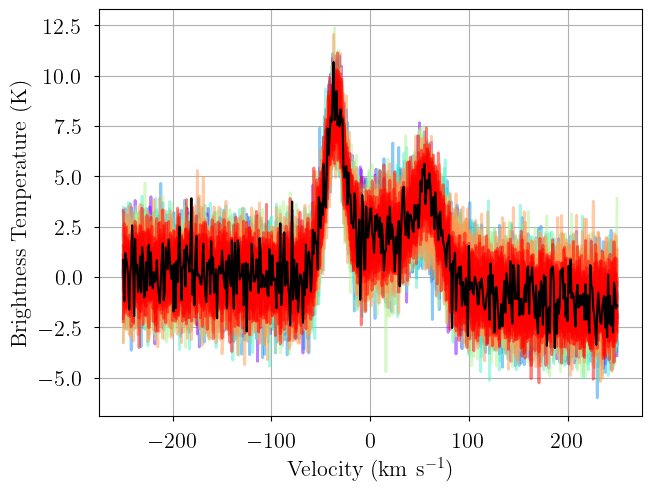

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

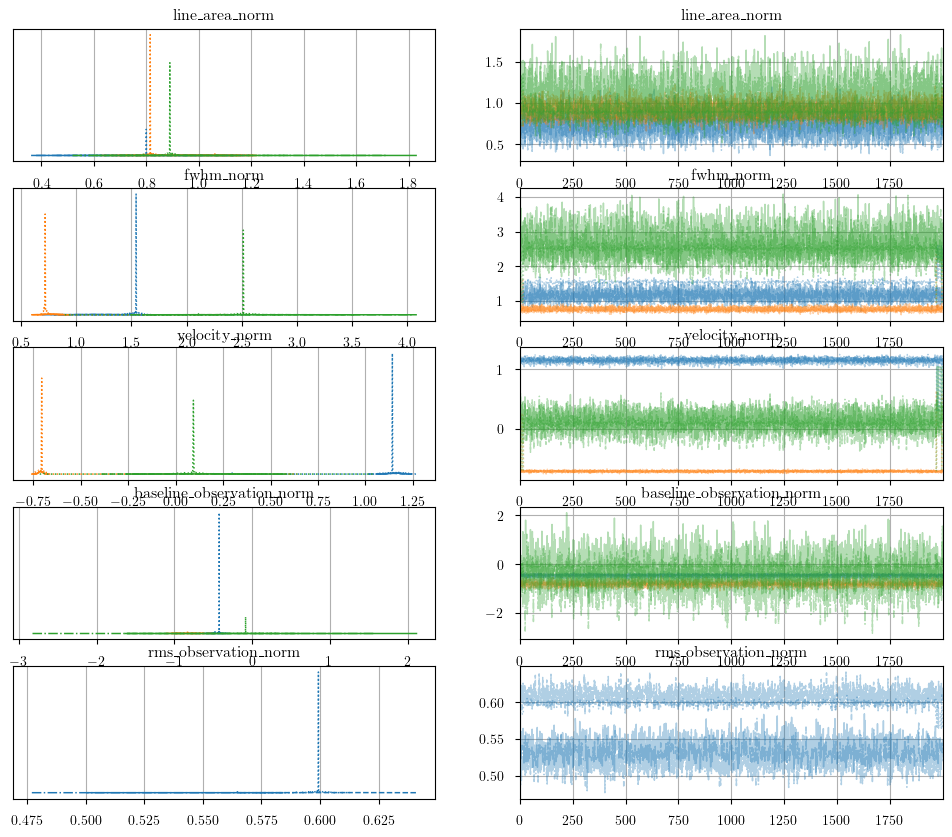

In [15]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [16]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [baseline_observation_norm, fwhm_norm, line_area_norm, observation, rms_observation_norm, velocity_norm]


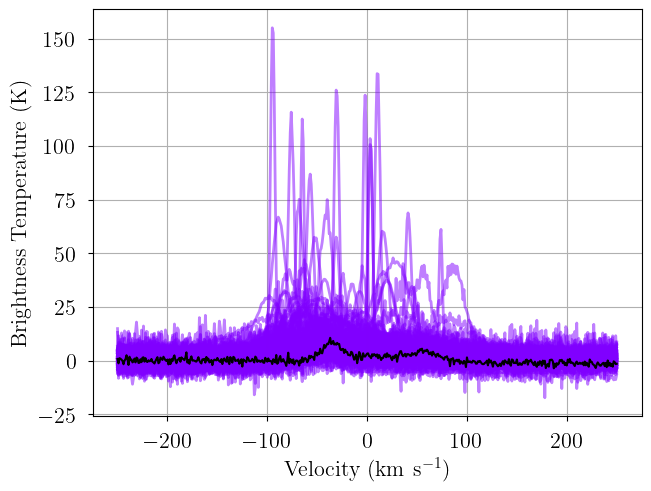

In [17]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [18]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

In [19]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

Sampling: [observation]


Output()

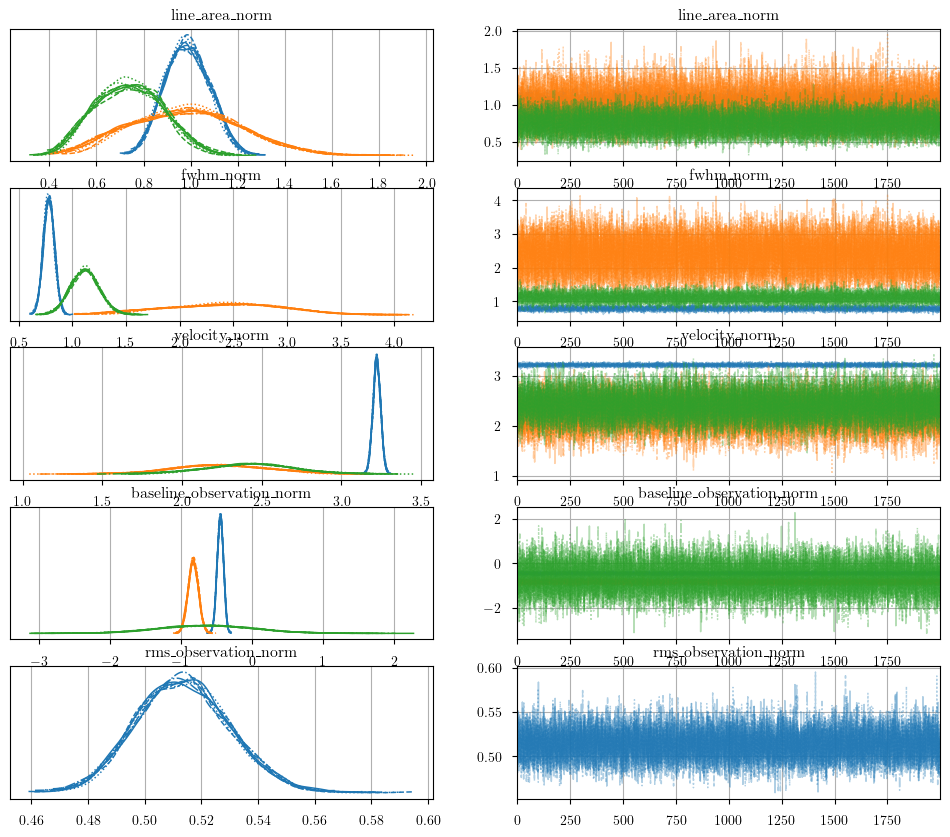

In [21]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [22]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    7.903   0.452    7.055    8.751      0.004   
amplitude[1]                    2.559   0.216    2.152    2.965      0.002   
amplitude[2]                    4.122   0.474    3.255    4.976      0.004   
baseline_observation_norm[0]   -0.451   0.044   -0.535   -0.370      0.000   
baseline_observation_norm[1]   -0.832   0.072   -0.968   -0.697      0.001   
baseline_observation_norm[2]   -0.647   0.660   -1.894    0.582      0.005   
fwhm[0]                        23.396   1.513   20.570   26.258      0.012   
fwhm[1]                        72.205  15.843   41.340   98.921      0.137   
fwhm[2]                        33.481   3.980   25.997   40.854      0.035   
fwhm_norm[0]                    0.780   0.050    0.686    0.875      0.000   
fwhm_norm[1]                    2.407   0.528    1.378    3.297      0.005   
fwhm_norm[2]                    1.116   0.133    0.867    1.362      0.001   
line_area[0]                  196.972  18.568  162.757  230.912      0.161   
line_area[1]                  196.491  45.872  110.293  277.942      0.394   
line_area[2]                  147.665  28.311   94.642  197.420      0.248   
line_area_norm[0]               0.985   0.093    0.814    1.155      0.001   
line_area_norm[1]               0.982   0.229    0.551    1.390      0.002   
line_area_norm[2]               0.738   0.142    0.473    0.987      0.001   
rms_observation                 1.027   0.033    0.968    1.090      0.000   
rms_observation_norm            0.514   0.016    0.484    0.545      0.000   
velocity[0]                   -35.568   0.481  -36.522  -34.712      0.004   
velocity[1]                     9.327   6.132   -1.520   21.633      0.054   
velocity[2]                    57.932   1.454   55.139   60.562      0.012   
velocity_norm[0]                3.222   0.024    3.174    3.264      0.000   
velocity_norm[1]                2.245   0.302    1.713    2.849      0.003   
velocity_norm[2]                2.430   0.276    1.894    2.948      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003   13820.0   13517.0    1.0  
amplitude[1]                    0.001   15600.0   14805.0    1.0  
amplitude[2]                    0.003   14236.0   11278.0    1.0  
baseline_observation_norm[0]    0.000   15316.0   14965.0    1.0  
baseline_observation_norm[1]    0.000   15332.0   15265.0    1.0  
baseline_observation_norm[2]    0.004   15190.0   15071.0    1.0  
fwhm[0]                         0.009   14710.0   14895.0    1.0  
fwhm[1]                         0.097   12900.0    9893.0    1.0  
fwhm[2]                         0.025   12915.0   11820.0    1.0  
fwhm_norm[0]                    0.000   14710.0   14895.0    1.0  
fwhm_norm[1]                    0.003   12900.0    9893.0    1.0  
fwhm_norm[2]                    0.001   12915.0   11820.0    1.0  
line_area[0]                    0.114   13367.0   12930.0    1.0  
line_area[1]                    0.278   12964.0   10500.0    1.0  
line_area[2]                    0.176   12587.0   10553.0    1.0  
line_area_norm[0]               0.001   13367.0   12930.0    1.0  
line_area_norm[1]               0.001   12964.0   10500.0    1.0  
line_area_norm[2]               0.001   12587.0   10553.0    1.0  
rms_observation                 0.000   13795.0   13867.0    1.0  
rms_observation_norm            0.000   13795.0   13867.0    1.0  
velocity[0]                     0.003   15706.0   14947.0    1.0  
velocity[1]                     0.039   12845.0   10960.0    1.0  
velocity[2]                     0.009   14248.0   12614.0    1.0  
velocity_norm[0]                0.000   15706.0   14947.0    1.0  
velocity_norm[1]                0.002   12764.0   10777.0    1.0  
velocity_norm[2]                0.002   12604.0   10327.0    1.0

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference). Thus we only consider the `GaussNoiseModel` model with `ordered=True`.

In [23]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [24]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

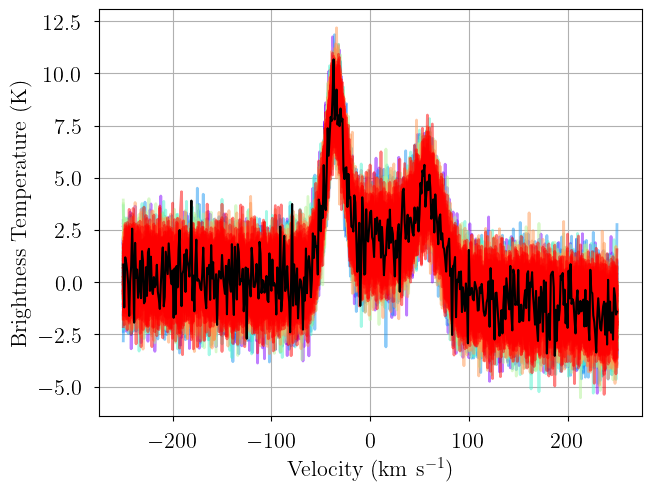

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

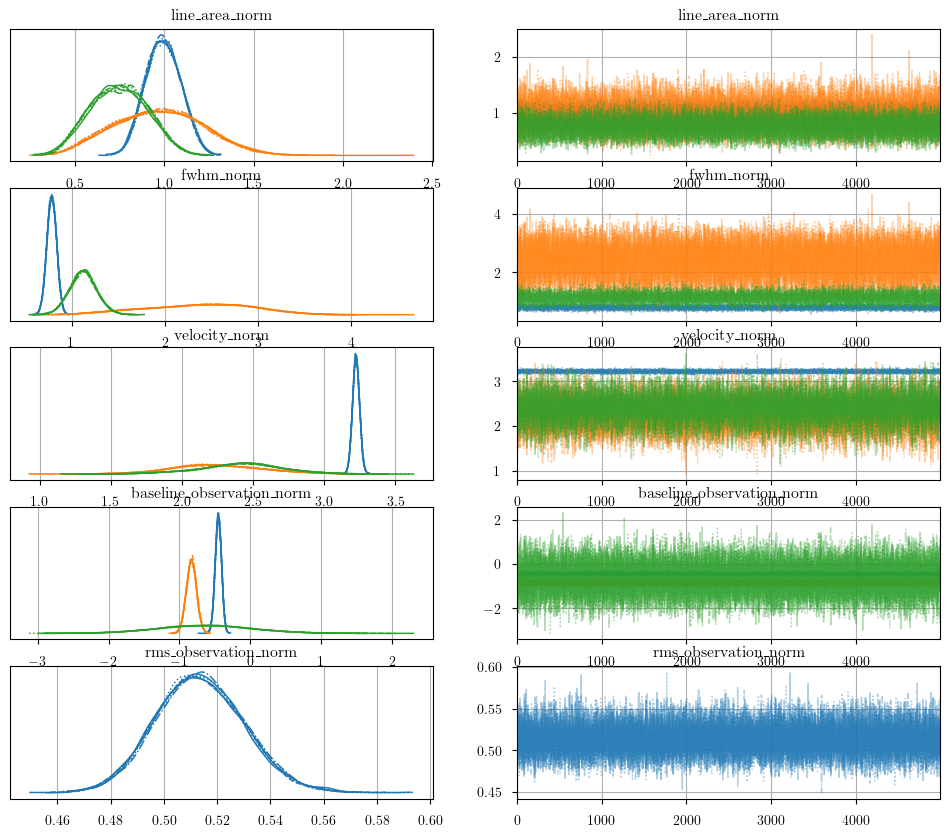

In [26]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [27]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    7.940   0.461    7.075    8.786      0.005   
amplitude[1]                    2.570   0.221    2.148    2.978      0.001   
amplitude[2]                    4.132   0.511    3.179    5.028      0.006   
baseline_observation_norm[0]   -0.452   0.044   -0.534   -0.367      0.000   
baseline_observation_norm[1]   -0.832   0.071   -0.963   -0.695      0.000   
baseline_observation_norm[2]   -0.643   0.660   -1.874    0.619      0.005   
fwhm[0]                        23.499   1.544   20.633   26.439      0.015   
fwhm[1]                        70.819  17.230   38.210  101.022      0.220   
fwhm[2]                        33.631   4.352   25.521   41.939      0.048   
fwhm_norm[0]                    0.783   0.051    0.688    0.881      0.000   
fwhm_norm[1]                    2.361   0.574    1.274    3.367      0.007   
fwhm_norm[2]                    1.121   0.145    0.851    1.398      0.002   
fwhm_norm_log__[0]             -0.246   0.066   -0.367   -0.120      0.001   
fwhm_norm_log__[1]              0.826   0.266    0.302    1.249      0.003   
fwhm_norm_log__[2]              0.106   0.132   -0.149    0.345      0.001   
line_area[0]                  198.816  19.468  163.017  234.972      0.232   
line_area[1]                  193.413  49.515   99.279  279.395      0.633   
line_area[2]                  149.024  31.656   88.820  204.300      0.407   
line_area_norm[0]               0.994   0.097    0.815    1.175      0.001   
line_area_norm[1]               0.967   0.248    0.496    1.397      0.003   
line_area_norm[2]               0.745   0.158    0.444    1.022      0.002   
line_area_norm_log__[0]        -0.011   0.099   -0.191    0.173      0.001   
line_area_norm_log__[1]        -0.069   0.272   -0.608    0.383      0.004   
line_area_norm_log__[2]        -0.318   0.222   -0.739    0.063      0.003   
rms_observation                 1.027   0.033    0.966    1.089      0.000   
rms_observation_norm            0.513   0.016    0.483    0.545      0.000   
rms_observation_norm_log__     -0.667   0.032   -0.728   -0.608      0.000   
velocity[0]                   -35.531   0.495  -36.488  -34.627      0.003   
velocity[1]                     9.508   6.600   -2.202   22.848      0.080   
velocity[2]                    57.795   1.573   54.689   60.581      0.015   
velocity_norm[0]                3.223   0.025    3.176    3.269      0.000   
velocity_norm[1]                2.252   0.325    1.675    2.908      0.004   
velocity_norm[2]                2.414   0.297    1.821    2.973      0.004   
velocity_norm_log__[0]          1.170   0.008    1.156    1.184      0.000   
velocity_norm_log__[1]          0.801   0.147    0.531    1.079      0.002   
velocity_norm_log__[2]          0.874   0.127    0.613    1.100      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003    9248.0   17236.0    1.0  
amplitude[1]                    0.001   25364.0   25469.0    1.0  
amplitude[2]                    0.004    7351.0   13746.0    1.0  
baseline_observation_norm[0]    0.000   17698.0   18765.0    1.0  
baseline_observation_norm[1]    0.000   39985.0   22427.0    1.0  
baseline_observation_norm[2]    0.003   19890.0   20537.0    1.0  
fwhm[0]                         0.011   10706.0   16612.0    1.0  
fwhm[1]                         0.156    6309.0    9277.0    1.0  
fwhm[2]                         0.034    8156.0   12629.0    1.0  
fwhm_norm[0]                    0.000   10706.0   16612.0    1.0  
fwhm_norm[1]                    0.005    6309.0    9277.0    1.0  
fwhm_norm[2]                    0.001    8156.0   12629.0    1.0  
fwhm_norm_log__[0]              0.000   10706.0   16612.0    1.0  
fwhm_norm_log__[1]              0.002    6309.0    9277.0    1.0  
fwhm_norm_log__[2]              0.001    8156.0   12629.0    1.0  
line_area[0]                    0.165    7012.0   12233.0    1.0  
line_ar

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [28]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [29]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

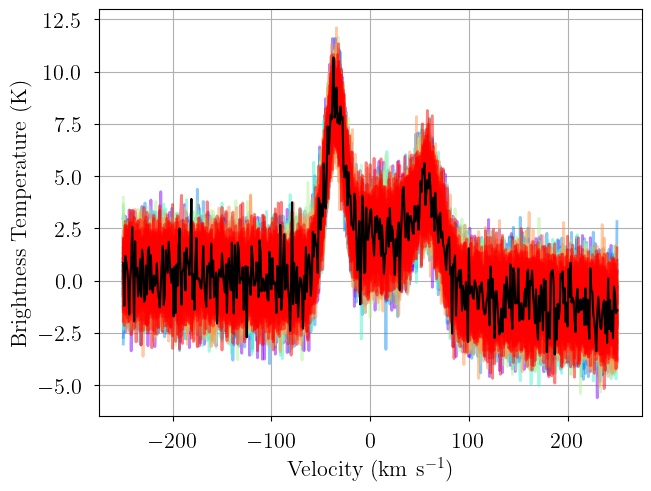

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

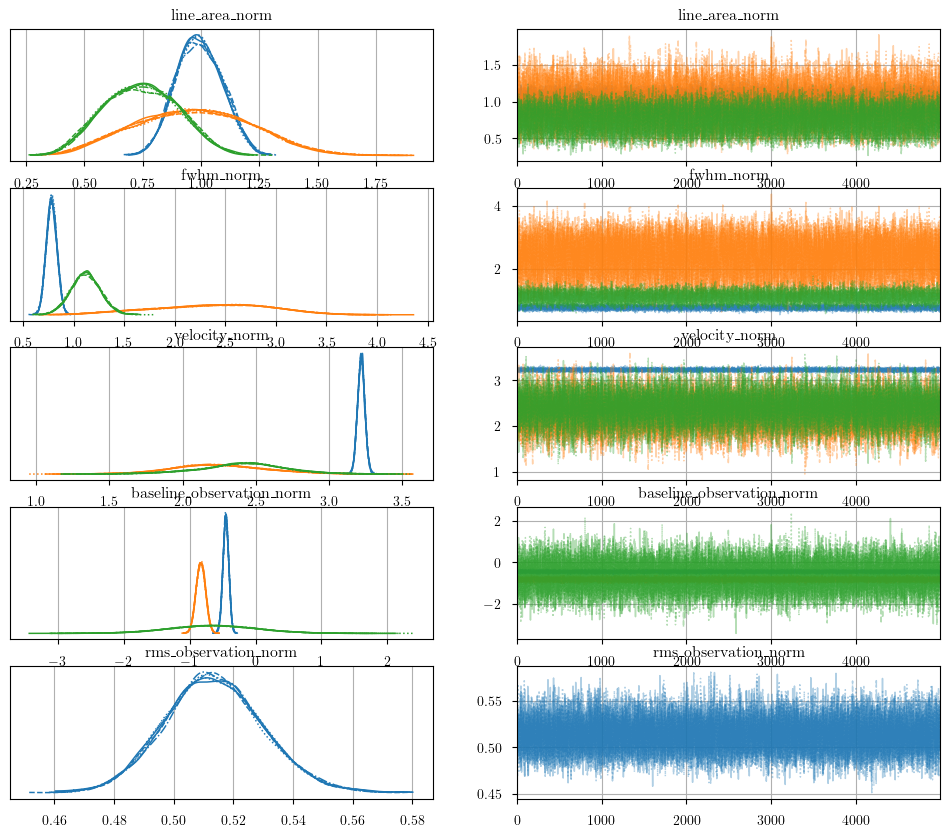

In [32]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [33]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    7.935   0.462    7.085    8.802      0.004   
amplitude[1]                    2.572   0.222    2.154    2.988      0.001   
amplitude[2]                    4.128   0.511    3.202    5.053      0.006   
baseline_observation_norm[0]   -0.452   0.044   -0.533   -0.366      0.000   
baseline_observation_norm[1]   -0.832   0.071   -0.966   -0.700      0.000   
baseline_observation_norm[2]   -0.646   0.662   -1.877    0.617      0.005   
fwhm[0]                        23.488   1.545   20.577   26.349      0.014   
fwhm[1]                        71.005  17.145   37.645  100.170      0.201   
fwhm[2]                        33.565   4.341   25.633   42.124      0.045   
fwhm_norm[0]                    0.783   0.052    0.686    0.878      0.000   
fwhm_norm[1]                    2.367   0.571    1.255    3.339      0.007   
fwhm_norm[2]                    1.119   0.145    0.854    1.404      0.002   
line_area[0]                  198.591  19.483  163.669  235.816      0.208   
line_area[1]                  194.128  49.490  102.071  282.413      0.586   
line_area[2]                  148.580  31.646   88.395  204.130      0.377   
line_area_norm[0]               0.993   0.097    0.818    1.179      0.001   
line_area_norm[1]               0.971   0.247    0.510    1.412      0.003   
line_area_norm[2]               0.743   0.158    0.442    1.021      0.002   
rms_observation                 1.027   0.033    0.966    1.090      0.000   
rms_observation_norm            0.513   0.016    0.483    0.545      0.000   
velocity[0]                   -35.539   0.495  -36.461  -34.603      0.003   
velocity[1]                     9.582   6.602   -2.319   22.859      0.071   
velocity[2]                    57.819   1.566   54.779   60.657      0.014   
velocity_norm[0]                3.223   0.025    3.177    3.270      0.000   
velocity_norm[1]                2.256   0.325    1.650    2.888      0.004   
velocity_norm[2]                2.412   0.297    1.818    2.972      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003   12954.0   20187.0    1.0  
amplitude[1]                    0.001   24983.0   24969.0    1.0  
amplitude[2]                    0.004    8635.0   16622.0    1.0  
baseline_observation_norm[0]    0.000   16443.0   19438.0    1.0  
baseline_observation_norm[1]    0.000   27356.0   21525.0    1.0  
baseline_observation_norm[2]    0.004   17420.0   19667.0    1.0  
fwhm[0]                         0.010   11509.0   17071.0    1.0  
fwhm[1]                         0.142    7510.0   10983.0    1.0  
fwhm[2]                         0.032    9244.0   13616.0    1.0  
fwhm_norm[0]                    0.000   11509.0   17071.0    1.0  
fwhm_norm[1]                    0.005    7510.0   10983.0    1.0  
fwhm_norm[2]                    0.001    9244.0   13616.0    1.0  
line_area[0]                    0.148    8757.0   14127.0    1.0  
line_area[1]                    0.414    7115.0   10935.0    1.0  
line_area[2]                    0.267    7026.0   12322.0    1.0  
line_area_norm[0]               0.001    8757.0   14127.0    1.0  
line_area_norm[1]               0.002    7115.0   10935.0    1.0  
line_area_norm[2]               0.001    7026.0   12322.0    1.0  
rms_observation                 0.000   26719.0   21406.0    1.0  
rms_observation_norm            0.000   26719.0   21406.0    1.0  
velocity[0]                     0.002   21496.0   20418.0    1.0  
velocity[1]                     0.052    8790.0   11151.0    1.0  
velocity[2]                     0.010   12743.0   16004.0    1.0  
velocity_norm[0]                0.000   21496.0   20418.0    1.0  
velocity_norm[1]                0.003    8764.0   11397.0    1.0  
velocity_norm[2]                0.002    9108.0   11069.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [34]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


In [35]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [36]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

Sampling: [observation]


Output()

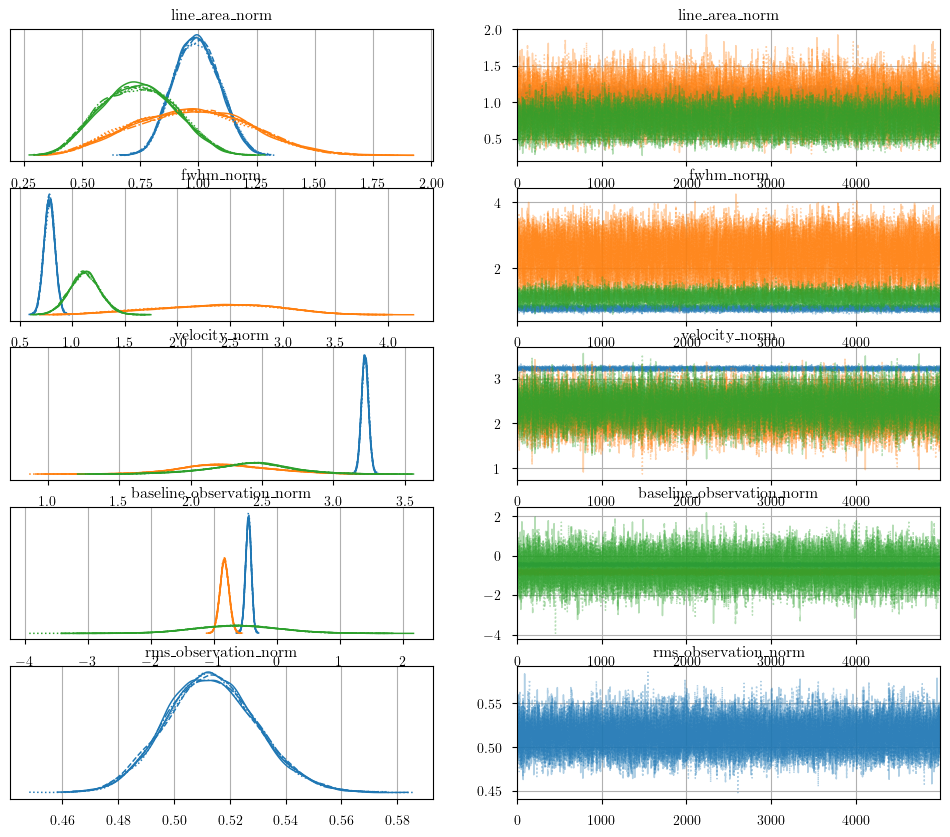

In [37]:
_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

In [38]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    7.937   0.463    7.079    8.801      0.004   
amplitude[1]                    2.573   0.221    2.172    3.002      0.001   
amplitude[2]                    4.127   0.508    3.196    5.034      0.005   
baseline_observation_norm[0]   -0.453   0.045   -0.535   -0.366      0.000   
baseline_observation_norm[1]   -0.833   0.071   -0.969   -0.701      0.000   
baseline_observation_norm[2]   -0.632   0.670   -1.874    0.640      0.005   
fwhm[0]                        23.485   1.537   20.585   26.363      0.014   
fwhm[1]                        71.178  17.177   38.162  100.737      0.199   
fwhm[2]                        33.572   4.307   25.443   41.698      0.044   
fwhm_norm[0]                    0.783   0.051    0.686    0.879      0.000   
fwhm_norm[1]                    2.373   0.573    1.272    3.358      0.007   
fwhm_norm[2]                    1.119   0.144    0.848    1.390      0.001   
line_area[0]                  198.588  19.325  162.886  234.242      0.201   
line_area[1]                  194.645  49.563  102.697  283.832      0.575   
line_area[2]                  148.544  31.438   90.429  205.371      0.367   
line_area_norm[0]               0.993   0.097    0.814    1.171      0.001   
line_area_norm[1]               0.973   0.248    0.513    1.419      0.003   
line_area_norm[2]               0.743   0.157    0.452    1.027      0.002   
rms_observation                 1.027   0.033    0.965    1.088      0.000   
rms_observation_norm            0.514   0.016    0.483    0.544      0.000   
velocity[0]                   -35.538   0.492  -36.459  -34.606      0.003   
velocity[1]                     9.578   6.523   -2.658   22.117      0.069   
velocity[2]                    57.821   1.551   54.771   60.646      0.014   
velocity_norm[0]                3.223   0.025    3.177    3.270      0.000   
velocity_norm[1]                2.256   0.322    1.664    2.887      0.003   
velocity_norm[2]                2.412   0.294    1.826    2.963      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003   13793.0   19903.0    1.0  
amplitude[1]                    0.001   24899.0   24696.0    1.0  
amplitude[2]                    0.004    9186.0   17142.0    1.0  
baseline_observation_norm[0]    0.000   15219.0   16751.0    1.0  
baseline_observation_norm[1]    0.000   27448.0   22059.0    1.0  
baseline_observation_norm[2]    0.004   16779.0   18296.0    1.0  
fwhm[0]                         0.010   12366.0   17162.0    1.0  
fwhm[1]                         0.141    7618.0   10547.0    1.0  
fwhm[2]                         0.031    9630.0   14772.0    1.0  
fwhm_norm[0]                    0.000   12366.0   17162.0    1.0  
fwhm_norm[1]                    0.005    7618.0   10547.0    1.0  
fwhm_norm[2]                    0.001    9630.0   14772.0    1.0  
line_area[0]                    0.143    9223.0   13878.0    1.0  
line_area[1]                    0.407    7366.0   10784.0    1.0  
line_area[2]                    0.259    7331.0   12795.0    1.0  
line_area_norm[0]               0.001    9223.0   13878.0    1.0  
line_area_norm[1]               0.002    7366.0   10784.0    1.0  
line_area_norm[2]               0.001    7331.0   12795.0    1.0  
rms_observation                 0.000   27580.0   20742.0    1.0  
rms_observation_norm            0.000   27580.0   20742.0    1.0  
velocity[0]                     0.002   21406.0   19856.0    1.0  
velocity[1]                     0.051    9165.0   12204.0    1.0  
velocity[2]                     0.010   13330.0   16325.0    1.0  
velocity_norm[0]                0.000   21406.0   19856.0    1.0  
velocity_norm[1]                0.002    9111.0   12151.0    1.0  
velocity_norm[2]                0.002    9428.0   11510.0    1.0